In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv


In [2]:
import pandas_profiling

In [3]:
train=pd.read_csv("../input/titanic/train.csv")
test=pd.read_csv("../input/titanic/test.csv")

In [4]:
#train.profile_report()

In [5]:
#train.info()

In [6]:
#test.profile_report()

Missing Vlaues

In [7]:
def missing_percentage(df):
    """This function takes a DataFrame(df) as input and returns two columns, total missing values and total missing values percentage"""
    ## the two following line may seem complicated but its actually very simple. 
    total = df.isnull().sum().sort_values(ascending = False)[df.isnull().sum().sort_values(ascending = False) != 0]
    percent = round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2)[round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2) != 0]
    return pd.concat([total, percent], axis=1, keys=['Total','Percent'])

In [8]:
missing_percentage(train)

,Total,Percent
Cabin,687,77.10
Age,177,19.87
Embarked,2,0.22


In [9]:
missing_percentage(test)

,Total,Percent
Cabin,327,78.23
Age,86,20.57
Fare,1,0.24


Filling missing values 

a.Embarked

In [10]:
def missing_value_count(df,feature):
    total=pd.DataFrame(df.loc[:,feature].value_counts(dropna=False))
    percent=round(total/len(df)*100,2)
    total.columns = ["Total"]
    percent.columns = ['Percent']
    return  pd.concat([total,percent],axis=1)

*.Embarked

In [11]:
missing_value_count(train,'Embarked')

,Total,Percent
S,644,72.28
C,168,18.86
Q,77,8.64
NaN,2,0.22


In [12]:
train[train.Embarked.isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [13]:
train.loc[(train['Survived'] == 1) & (train['Pclass'] == 1) & (train['Sex']=='female' )].loc[:,'Embarked'].value_counts()

S    46
C    42
Q     1
Name: Embarked, dtype: int64

Taking majority

In [14]:
train.Embarked.fillna('S',inplace=True)

*Cabin

In [15]:
#FOR imputation of cabin feature we concat the train and test set
survivers=train.Survived

In [16]:
train.drop('Survived',inplace=True,axis=1)

In [17]:
all_data=pd.concat([train,test],ignore_index=False)

In [18]:
all_data.Cabin.fillna('N',inplace=True)

In [19]:
all_data.Cabin=[i[0] for i in all_data.Cabin]

In [20]:
missing_value_count(all_data,'Cabin')

,Total,Percent
N,1014,77.46
C,94,7.18
B,65,4.97
D,46,3.51
E,41,3.13
A,22,1.68
F,21,1.60
G,5,0.38
T,1,0.08


In [21]:
with_N=all_data[all_data.Cabin=='N']

In [22]:
without_N=all_data[all_data.Cabin!='N']

In [23]:
all_data.groupby('Cabin').Fare.mean().sort_values(ascending=False)

Cabin
B    122.383078
C    107.926598
E     54.564634
D     53.007339
A     41.244314
T     35.500000
N     19.132707
F     18.079367
G     14.205000
Name: Fare, dtype: float64

In [24]:
all_data.Cabin.value_counts(ascending=False)

N    1014
C      94
B      65
D      46
E      41
A      22
F      21
G       5
T       1
Name: Cabin, dtype: int64

In [25]:
def cabin_estimator(i):
    """Grouping cabin feature by the first letter"""
    a = 0
    if i<16:
        a = "G"
    elif i>=16 and i<27:
        a = "F"
    elif i>=27 and i<38:
        a = "T"
    elif i>=38 and i<47:
        a = "A"
    elif i>= 47 and i<53:
        a = "E"
    elif i>= 53 and i<54:
        a = "D"
    elif i>=54 and i<116:
        a = 'C'
    else:
        a = "B"
    return a

In [26]:
with_N['Cabin']=with_N.Fare.apply(lambda x: cabin_estimator(x))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [27]:
with_N.Cabin.unique()

array(['G', 'F', 'T', 'C', 'E', 'A', 'B'], dtype=object)

In [28]:
## getting back train. 
all_data = pd.concat([with_N, without_N], axis=0)
## PassengerId helps us separate train and test. 
all_data.sort_values(by = 'PassengerId', inplace=True)

In [29]:
all_data.Cabin.unique()

array(['G', 'C', 'E', 'F', 'T', 'D', 'A', 'B'], dtype=object)

In [30]:
## Separating train and test from all_data. 
train = all_data[:891]#exclude 891 means up to 890 index value

test = all_data[891:]

In [31]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Name         891 non-null    object 
 3   Sex          891 non-null    object 
 4   Age          714 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Cabin        891 non-null    object 
 10  Embarked     891 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [32]:
train['Survived']=survivers

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [33]:
test[test.Fare.isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,B,S


In [34]:
missing_value=test[(test.Pclass==3)&(test.Sex=='male')&(test.Embarked=='S')].Fare.mean()

In [35]:
missing_value

12.718872

In [36]:
test.Fare.fillna(missing_value,inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Survived/Non-Survived Passenger Gender Distribution')

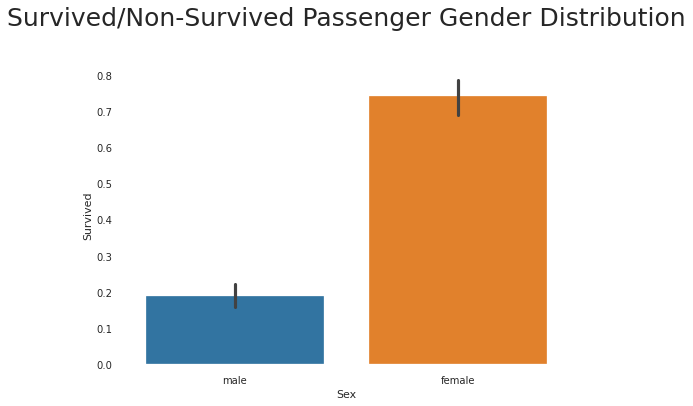

In [38]:
sns.barplot(x = "Sex", 
                 y = "Survived", 
                 data=train, 
#                 linewidth=5,
 #                capsize = .05,

                )

plt.title("Survived/Non-Survived Passenger Gender Distribution", fontsize = 25,loc = 'center', pad = 40)

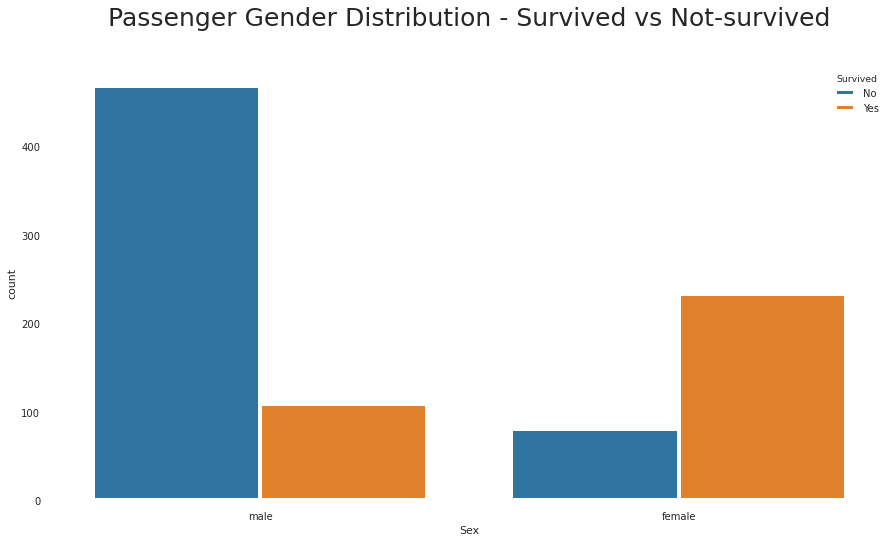

In [39]:
plt.subplots(figsize = (15,8))
ax = sns.countplot(x = "Sex", 
                   hue="Survived",
                   data = train, 
                   linewidth=4,
)
plt.title("Passenger Gender Distribution - Survived vs Not-survived", fontsize = 25, pad=40)
leg = ax.get_legend()
leg.set_title("Survived")
legs = leg.texts
legs[0].set_text("No")
legs[1].set_text("Yes")
plt.show()    

In [40]:
train.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Survived
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,2.308642,29.699118,0.523008,0.381594,32.204208,0.383838
std,257.353842,0.836071,14.526497,1.102743,0.806057,49.693429,0.486592
min,1.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,2.000000,20.125000,0.000000,0.000000,7.910400,0.000000
50%,446.000000,3.000000,28.000000,0.000000,0.000000,14.454200,0.000000
75%,668.500000,3.000000,38.000000,1.000000,0.000000,31.000000,1.000000
max,891.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000


Text(0.5, 1.03, 'Correlations Among Features')

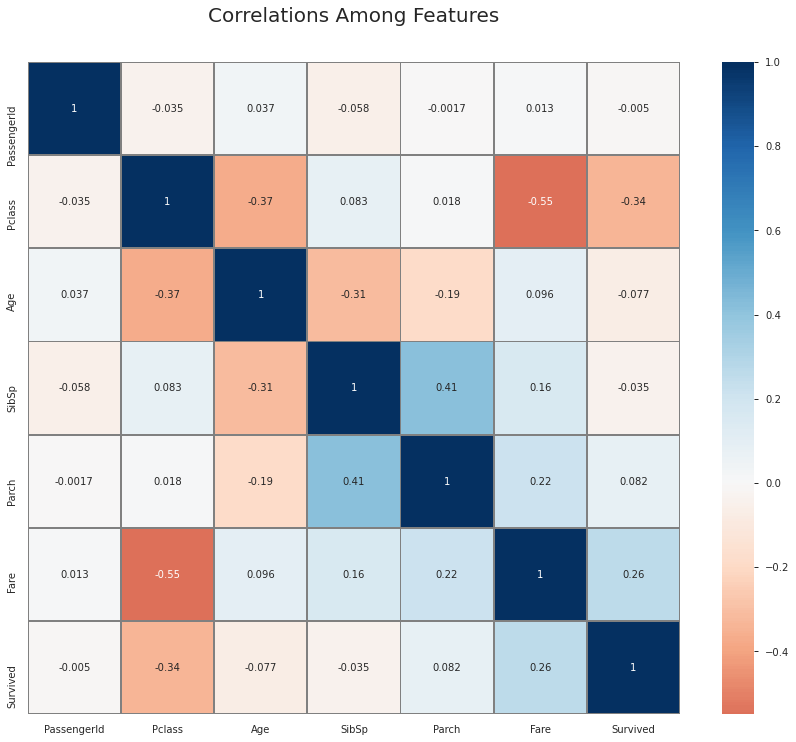

In [41]:
#Heatmap
#representing correlation 
plt.subplots(figsize = (15,12))
sns.heatmap(train.corr(),annot=True,cmap = 'RdBu',linewidths=.9,linecolor='grey', center = 0,square=True)
plt.title("Correlations Among Features", y = 1.03,fontsize = 20, pad = 40)

Feature Engineering

1.Name

In [42]:
#Creating feature that conatins name length
train['name_length']=[len(i) for i in train.Name]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [43]:
test['name_length']=[len(i) for i in test.Name]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [44]:
def name_length_group(size):
    a=''
    if (size<=20):
        a='short'
    elif(size<=35):
        a='medium'
    elif (size<=45):
        a='good'
    else:
        a='long'
    return a
                

In [45]:
train['nlength_group']=train['name_length'].map(name_length_group)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [46]:
test['nlength_group']=test['name_length'].map(name_length_group)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [47]:
train['title']=[i.split('.')[0] for i in train.Name]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [48]:
train['title']=[i.split(',')[1] for i in train.title]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [49]:
test['title']=[i.split('.')[0] for i in test.Name]
test['title']=[i.split(',')[1] for i in test.title]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [50]:
train['title']=[i.replace('Ms','Miss') for i in train.title]
train["title"] = [i.replace('Mlle', 'Miss') for i in train.title]
train["title"] = [i.replace('Mme', 'Mrs') for i in train.title]
train["title"] = [i.replace('Dr', 'rare') for i in train.title]
train["title"] = [i.replace('Col', 'rare') for i in train.title]
train["title"] = [i.replace('Major', 'rare') for i in train.title]
train["title"] = [i.replace('Don', 'rare') for i in train.title]
train["title"] = [i.replace('Jonkheer', 'rare') for i in train.title]
train["title"] = [i.replace('Sir', 'rare') for i in train.title]
train["title"] = [i.replace('Lady', 'rare') for i in train.title]
train["title"] = [i.replace('Capt', 'rare') for i in train.title]
train["title"] = [i.replace('the Countess', 'rare') for i in train.title]
train["title"] = [i.replace('Rev', 'rare') for i in train.title]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [51]:
test['title'] = [i.replace('Ms', 'Miss') for i in test.title]
test['title'] = [i.replace('Dr', 'rare') for i in test.title]
test['title'] = [i.replace('Col', 'rare') for i in test.title]
test['title'] = [i.replace('Dona', 'rare') for i in test.title]
test['title'] = [i.replace('Rev', 'rare') for i in test.title]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [52]:
test.title.unique()

array([' Mr', ' Mrs', ' Miss', ' Master', ' rare'], dtype=object)

In [53]:
train[['Sex','title']].groupby('title').count()

,Sex
title,
Master,40
Miss,185
Mr,517
Mrs,126
rare,23


In [54]:
train['family_size']=train.SibSp+train.Parch+1
test['family_size']=test.SibSp+test.Parch+1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [55]:
print(train.family_size.unique())
print(test.family_size.unique())

[ 2  1  5  3  7  6  4  8 11]
[ 1  2  3  5  4  6  8  7 11]


In [56]:
def family_group(size):
    a=''
    if (size<=1):
        a='loner'
    elif (size<=4):
        a='small'
    else:
        a='large'
    return a

In [57]:
train["family_group"]=train.family_size.map(family_group)
train.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived,name_length,nlength_group,title,family_size,family_group
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,G,S,0,23,medium,Mr,2,small
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C,1,51,long,Mrs,2,small
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,G,S,1,22,medium,Miss,1,loner
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S,1,44,good,Mrs,2,small
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,G,S,0,24,medium,Mr,1,loner


In [58]:
test['family_group'] = test['family_size'].map(family_group)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [59]:
train['is_alone'] = [1 if i<2 else 0 for i in train.family_size]
test['is_alone'] = [1 if i<2 else 0 for i in test.family_size]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [60]:
train.drop(['Ticket'], axis=1, inplace=True)
test.drop(['Ticket'], axis=1, inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [61]:
train['calculated_fare']=train.Fare/train.family_size
train.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Survived,name_length,nlength_group,title,family_size,family_group,is_alone,calculated_fare
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,G,S,0,23,medium,Mr,2,small,0,3.62500
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,C,1,51,long,Mrs,2,small,0,35.64165
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,G,S,1,22,medium,Miss,1,loner,1,7.92500
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,C,S,1,44,good,Mrs,2,small,0,26.55000
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,G,S,0,24,medium,Mr,1,loner,1,8.05000


In [62]:
test['calculated_fare']=test.Fare/test.family_size

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [63]:
bins=[0,4,10,20,45,600]
group=['very_low','small','medium','high','very_high']
train['fare_group']=pd.cut(train['calculated_fare'],bins,labels=group)
test['fare_group']=pd.cut(test['calculated_fare'],bins,labels=group)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [64]:
train.drop(['PassengerId'], axis=1, inplace=True)

test.drop(['PassengerId'], axis=1, inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [65]:
train = pd.get_dummies(train, columns=['title',"Pclass", 'Cabin','Embarked','nlength_group', 'family_group', 'fare_group'], drop_first=False)

In [66]:
test = pd.get_dummies(test, columns=['title',"Pclass",'Cabin','Embarked','nlength_group', 'family_group', 'fare_group'], drop_first=False)
train.drop(['family_size','Name', 'Fare','name_length'], axis=1, inplace=True)

In [67]:
test.drop(['Name','family_size',"Fare",'name_length'], axis=1, inplace=True)

In [68]:
train = pd.concat([train[["Survived", "Age", "Sex","SibSp","Parch"]], train.loc[:,"is_alone":]], axis=1)
test = pd.concat([test[["Age", "Sex"]], test.loc[:,"SibSp":]], axis=1)

In [69]:
from sklearn.ensemble import RandomForestRegressor

In [70]:
def completing_age(df):
    ## gettting all the features except survived
    age_df = df.loc[:,"Age":] 
    
    temp_train = age_df.loc[age_df.Age.notnull()] ## df with age values
    temp_test = age_df.loc[age_df.Age.isnull()] ## df without age values
    
    y = temp_train.Age.values ## setting target variables(age) in y 
    x = temp_train.loc[:, "Sex":].values
    
    rfr = RandomForestRegressor(n_estimators=1500, n_jobs=-1)
    rfr.fit(x, y)
    
    predicted_age = rfr.predict(temp_test.loc[:, "Sex":])
    
    df.loc[df.Age.isnull(), "Age"] = predicted_age
    

    return df

In [71]:
train.Sex=train.Sex.apply(lambda x : 0 if x=='female' else 1)
test.Sex=test.Sex.apply(lambda x : 0 if x=='female' else 1)

In [72]:
completing_age(train)

,Survived,Age,Sex,SibSp,Parch,is_alone,calculated_fare,title_ Master,title_ Miss,title_ Mr,...,nlength_group_medium,nlength_group_short,family_group_large,family_group_loner,family_group_small,fare_group_very_low,fare_group_small,fare_group_medium,fare_group_high,fare_group_very_high
0,0,22.000000,1,1,0,0,3.62500,0,0,1,...,1,0,0,0,1,1,0,0,0,0
1,1,38.000000,0,1,0,0,35.64165,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,1,26.000000,0,0,0,1,7.92500,0,1,0,...,1,0,0,1,0,0,1,0,0,0
3,1,35.000000,0,1,0,0,26.55000,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,0,35.000000,1,0,0,1,8.05000,0,0,1,...,1,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,27.000000,1,0,0,1,13.00000,0,0,0,...,1,0,0,1,0,0,0,1,0,0
887,1,19.000000,0,0,0,1,30.00000,0,1,0,...,1,0,0,1,0,0,0,0,1,0
888,0,10.060954,0,1,2,0,5.86250,0,1,0,...,0,0,0,0,1,0,1,0,0,0
889,1,26.000000,1,0,0,1,30.00000,0,0,1,...,1,0,0,1,0,0,0,0,1,0


In [73]:
completing_age(test);

In [74]:
## create bins for age
def age_group_fun(age):
    a = ''
    if age <= 1:
        a = 'infant'
    elif age <= 4: 
        a = 'toddler'
    elif age <= 13:
        a = 'child'
    elif age <= 18:
        a = 'teenager'
    elif age <= 35:
        a = 'Young_Adult'
    elif age <= 45:
        a = 'adult'
    elif age <= 55:
        a = 'middle_aged'
    elif age <= 65:
        a = 'senior_citizen'
    else:
        a = 'old'
    return a
        
## Applying "age_group_fun" function to the "Age" column.
train['age_group'] = train['Age'].map(age_group_fun)
test['age_group'] = test['Age'].map(age_group_fun)

## Creating dummies for "age_group" feature. 
train = pd.get_dummies(train,columns=['age_group'], drop_first=True)
test = pd.get_dummies(test,columns=['age_group'], drop_first=True);

train.drop('Age', axis=1, inplace=True)
test.drop('Age', axis=1, inplace=True)

In [75]:
X = train.drop(['Survived'], axis = 1)
y = train["Survived"]

In [76]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = .33, random_state=0)

In [77]:
headers = X_train.columns 

X_train.head()

,Sex,SibSp,Parch,is_alone,calculated_fare,title_ Master,title_ Miss,title_ Mr,title_ Mrs,title_ rare,...,fare_group_high,fare_group_very_high,age_group_adult,age_group_child,age_group_infant,age_group_middle_aged,age_group_old,age_group_senior_citizen,age_group_teenager,age_group_toddler
242,1,0,0,1,10.50,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
344,1,0,0,1,13.00,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
170,1,0,0,1,33.50,0,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0
187,1,0,0,1,26.55,0,0,1,0,0,...,1,0,1,0,0,0,0,0,0,0
800,1,0,0,1,13.00,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [78]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

## transforming "train_x"
X_train = sc.fit_transform(X_train)
## transforming "test_x"
X_test = sc.transform(X_test)

## transforming "The testset"
test = sc.transform(test)

In [79]:
pd.DataFrame(X_train, columns=headers).head()

,Sex,SibSp,Parch,is_alone,calculated_fare,title_ Master,title_ Miss,title_ Mr,title_ Mrs,title_ rare,...,fare_group_high,fare_group_very_high,age_group_adult,age_group_child,age_group_infant,age_group_middle_aged,age_group_old,age_group_senior_citizen,age_group_teenager,age_group_toddler
0,0.724083,-0.455235,-0.469509,0.803996,-0.281753,-0.226156,-0.499476,0.832575,-0.405046,-0.143346,...,-0.462438,-0.305905,-0.475749,-0.230225,-0.123823,-0.295958,-0.09198,-0.200349,-0.285779,-0.191107
1,0.724083,-0.455235,-0.469509,0.803996,-0.209699,-0.226156,-0.499476,0.832575,-0.405046,-0.143346,...,-0.462438,-0.305905,2.101947,-0.230225,-0.123823,-0.295958,-0.09198,-0.200349,-0.285779,-0.191107
2,0.724083,-0.455235,-0.469509,0.803996,0.381139,-0.226156,-0.499476,0.832575,-0.405046,-0.143346,...,2.162450,-0.305905,-0.475749,-0.230225,-0.123823,-0.295958,-0.09198,4.991297,-0.285779,-0.191107
3,0.724083,-0.455235,-0.469509,0.803996,0.180831,-0.226156,-0.499476,0.832575,-0.405046,-0.143346,...,2.162450,-0.305905,2.101947,-0.230225,-0.123823,-0.295958,-0.09198,-0.200349,-0.285779,-0.191107
4,0.724083,-0.455235,-0.469509,0.803996,-0.209699,-0.226156,-0.499476,0.832575,-0.405046,-0.143346,...,-0.462438,-0.305905,-0.475749,-0.230225,-0.123823,-0.295958,-0.09198,-0.200349,-0.285779,-0.191107


In [80]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error,accuracy_score
logreg=LogisticRegression(solver='liblinear',penalty='l1')
logreg.fit(X_train,y_train)
y_pred=logreg.predict(X_test)
print('Our accuracy score is :{}'.format(round(accuracy_score(y_pred,y_test),4)))

Our accuracy score is :0.8203


In [81]:
#use of cross-validation
from sklearn.model_selection import StratifiedShuffleSplit,cross_val_score
cv=StratifiedShuffleSplit(n_splits=10,test_size=.25,random_state=0)
## saving the feature names for decision tree display
column_names = X.columns

In [82]:
X = sc.fit_transform(X)


In [83]:
accuracies = cross_val_score(LogisticRegression(solver='liblinear'), X,y, cv  = cv)

In [84]:
print ("Cross-Validation accuracy scores:{}".format(accuracies))
print ("Mean Cross-Validation accuracy score: {}".format(round(accuracies.mean(),5)))

Cross-Validation accuracy scores:[0.81165919 0.80269058 0.8206278  0.86547085 0.8206278  0.8161435
 0.8206278  0.86547085 0.80717489 0.82959641]
Mean Cross-Validation accuracy score: 0.82601


In [85]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
C_vals = [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,3,4,5,6,7,8,9,10,12,13,14,15,16,16.5,17,17.5,18]
penalties = ['l1','l2']
cv = StratifiedShuffleSplit(n_splits = 10, test_size = .25)
param = {'penalty': penalties, 'C': C_vals}
logreg = LogisticRegression(solver='liblinear')
grid = GridSearchCV(estimator=LogisticRegression(),param_grid = param,scoring = 'accuracy',n_jobs =-1,cv = cv)
grid.fit(X, y)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=None, test_size=0.25,
            train_size=None),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 3,
                               4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 16.5,
                               17, 17.5, 18],
                         'penalty': ['l1', 'l2']},
             scoring='accuracy')

In [86]:
## Getting the best of everything. 
print (grid.best_score_)
print (grid.best_params_)
print(grid.best_estimator_)

0.8264573991031391
{'C': 0.2, 'penalty': 'l2'}
LogisticRegression(C=0.2)


In [87]:
### Using the best parameters from the grid-search.
logreg_grid = grid.best_estimator_
logreg_grid.score(X,y)

0.8439955106621774

In [88]:
from sklearn.neighbors import KNeighborsClassifier
## calling on the model oject. 
knn = KNeighborsClassifier(metric='minkowski', p=2)
## knn classifier works by doing euclidian distance 


## doing 10 fold staratified-shuffle-split cross validation 
cv = StratifiedShuffleSplit(n_splits=10, test_size=.25, random_state=2)

accuracies = cross_val_score(knn, X,y, cv = cv, scoring='accuracy')
print ("Cross-Validation accuracy scores:{}".format(accuracies))
print ("Mean Cross-Validation accuracy score: {}".format(round(accuracies.mean(),3)))

Cross-Validation accuracy scores:[0.77578475 0.78475336 0.78475336 0.81165919 0.82511211 0.77578475
 0.78475336 0.80269058 0.79372197 0.82511211]
Mean Cross-Validation accuracy score: 0.796


In [89]:
k_range = range(1,31)
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X,y, cv = cv, scoring = 'accuracy')
    k_scores.append(scores.mean())
print("Accuracy scores are: {}\n".format(k_scores))
print ("Mean accuracy score: {}".format(np.mean(k_scores)))

Accuracy scores are: [0.7497757847533633, 0.7668161434977578, 0.7811659192825113, 0.8022421524663678, 0.7964125560538117, 0.7923766816143498, 0.7919282511210762, 0.7923766816143497, 0.7977578475336322, 0.789237668161435, 0.7919282511210761, 0.7825112107623319, 0.7910313901345292, 0.7834080717488789, 0.7892376681614349, 0.7802690582959642, 0.7887892376681613, 0.7856502242152466, 0.7874439461883408, 0.7780269058295964, 0.7852017937219731, 0.7793721973094171, 0.7860986547085201, 0.7757847533632287, 0.7771300448430493, 0.7663677130044843, 0.7699551569506726, 0.7609865470852019, 0.7659192825112108, 0.762780269058296]

Mean accuracy score: 0.7815994020926756


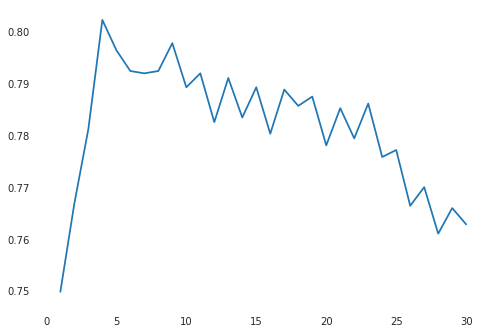

In [90]:
from matplotlib import pyplot as plt
plt.plot(k_range, k_scores)

In [91]:
from sklearn.model_selection import GridSearchCV
## trying out multiple values for k
k_range = range(1,31)
## 
weights_options=['uniform','distance']
# 
param = {'n_neighbors':k_range, 'weights':weights_options}
## Using startifiedShufflesplit. 
cv = StratifiedShuffleSplit(n_splits=10, test_size=.30, random_state=15)
# estimator = knn, param_grid = param, n_jobs = -1 to instruct scikit learn to use all available processors. 
knn_grid = GridSearchCV(KNeighborsClassifier(), param,cv=cv,verbose = False, n_jobs=-1)
## Fitting the model. 
knn_grid.fit(X,y)
knn_estimator= knn_grid.best_estimator_
knn_estimator.score(X,y)

0.8585858585858586

In [92]:
from sklearn.model_selection import RandomizedSearchCV
## trying out multiple values for k
k_range = range(1,31)
## 
weights_options=['uniform','distance']
# 
param = {'n_neighbors':k_range, 'weights':weights_options}
## Using startifiedShufflesplit. 
cv = StratifiedShuffleSplit(n_splits=10, test_size=.30)
# estimator = knn, param_grid = param, n_jobs = -1 to instruct scikit learn to use all available processors. 
## for RandomizedSearchCV, 
rgrid = RandomizedSearchCV(KNeighborsClassifier(), param,cv=cv,verbose = False, n_jobs=-1, n_iter=40)
## Fitting the model. 
rgrid.fit(X,y)
knn_restimator = rgrid.best_estimator_
knn_restimator.score(X,y)

0.819304152637486

In [93]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

gaussian = GaussianNB()
gaussian.fit(X, y)
y_pred = gaussian.predict(X_test)
gaussian_accy = round(accuracy_score(y_pred, y_test), 3)
print(gaussian_accy)

0.803


In [94]:
from sklearn.svm import SVC
Cs = [0.001, 0.01, 0.1, 1,1.5,2,2.5,3,4,5, 10] ## penalty parameter C for the error term. 
gammas = [0.0001,0.001, 0.01, 0.1, 1]
param_grid = {'C': Cs, 'gamma' : gammas}
cv = StratifiedShuffleSplit(n_splits=10, test_size=.30, random_state=15)
sv_grid = GridSearchCV(SVC(kernel = 'rbf', probability=True), param_grid, cv=cv) ## 'rbf' stands for gaussian kernel
sv_grid.fit(X,y)
sv_estimator = sv_grid.best_estimator_
sv_estimator.score(X,y)

0.8383838383838383

In [95]:
from sklearn.tree import DecisionTreeClassifier
max_depth = range(1,30)
max_feature = [21,22,23,24,25,26,28,29,30,'auto']
criterion=["entropy", "gini"]

param = {'max_depth':max_depth, 
         'max_features':max_feature, 
         'criterion': criterion}
dt_grid = GridSearchCV(DecisionTreeClassifier(), 
                                param_grid = param, 
                                 verbose=False, 
                                 cv=StratifiedKFold(n_splits=20, random_state=15, shuffle=True),
                                n_jobs = -1)
dt_grid.fit(X, y) 
dt_estimator = dt_grid.best_estimator_ 
dt_estimator.score(X,y)

0.8540965207631874

In [96]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
n_estimators = [140,145,150,155,160];
max_depth = range(1,10);
criterions = ['gini', 'entropy'];
cv = StratifiedShuffleSplit(n_splits=10, test_size=.30, random_state=15)


parameters = {'n_estimators':n_estimators,
              'max_depth':max_depth,
              'criterion': criterions
              
        }
rf_grid = GridSearchCV(estimator=RandomForestClassifier(max_features='auto'),
                                 param_grid=parameters,
                                 cv=cv,
                                 n_jobs = -1)
rf_grid.fit(X,y) 
rf_estimator=rf_grid.best_estimator_
rf_estimator.score(X,y)

0.8428731762065096

In [97]:
from sklearn.ensemble import BaggingClassifier
n_estimators = [10,30,50,70,80,150,160, 170,175,180,185];
cv = StratifiedShuffleSplit(n_splits=10, test_size=.30, random_state=15)

parameters = {'n_estimators':n_estimators,
              
        }
grid = GridSearchCV(BaggingClassifier(base_estimator= None, ## If None, then the base estimator is a decision tree.
                                      bootstrap_features=False),
                                 param_grid=parameters,
                                 cv=cv,
                                 n_jobs = -1)
grid.fit(X,y) 
grid.best_score_
grid.best_params_
grid.best_estimator_
bagging_grid = grid.best_estimator_
bagging_grid.score(X,y)
bagging_grid = grid.best_estimator_
bagging_estimator=grid.best_estimator_
bagging_grid.score(X,y)

0.9629629629629629

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

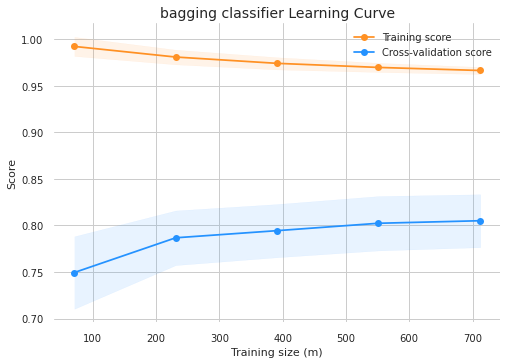

In [98]:

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold, StratifiedShuffleSplit,learning_curve
def plot_learning_curve(estimator1, X, y, ylim=None, cv=None,n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    f, ax1 = plt.subplots()
    # First Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator1, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax1.set_title("bagging classifier Learning Curve", fontsize=14)
    ax1.set_xlabel('Training size (m)')
    ax1.set_ylabel('Score')
    ax1.grid(True)
    ax1.legend(loc="best")
    return plt
cv = StratifiedShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plot_learning_curve(bagging_estimator, X, y, cv=cv, n_jobs=4)

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

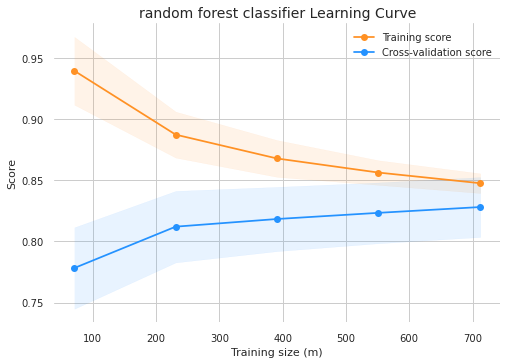

In [99]:

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold, StratifiedShuffleSplit,learning_curve
def plot_learning_curve(estimator1, X, y, ylim=None, cv=None,n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    f, ax1 = plt.subplots()
    # First Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator1, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax1.set_title("random forest classifier Learning Curve", fontsize=14)
    ax1.set_xlabel('Training size (m)')
    ax1.set_ylabel('Score')
    ax1.grid(True)
    ax1.legend(loc="best")
    return plt
cv = StratifiedShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plot_learning_curve(rf_estimator, X, y, cv=cv, n_jobs=4)

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

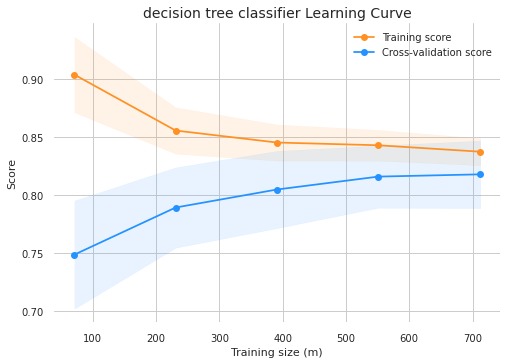

In [100]:

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold, StratifiedShuffleSplit,learning_curve
def plot_learning_curve(estimator1, X, y, ylim=None, cv=None,n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    f, ax1 = plt.subplots()
    # First Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator1, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax1.set_title("decision tree classifier Learning Curve", fontsize=14)
    ax1.set_xlabel('Training size (m)')
    ax1.set_ylabel('Score')
    ax1.grid(True)
    ax1.legend(loc="best")
    return plt
cv = StratifiedShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plot_learning_curve(dt_estimator, X, y, cv=cv, n_jobs=4)

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

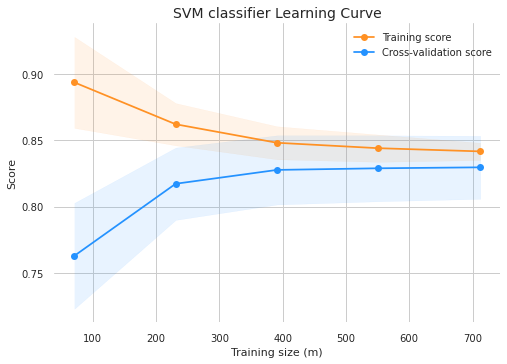

In [101]:

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold, StratifiedShuffleSplit,learning_curve
def plot_learning_curve(estimator1, X, y, ylim=None, cv=None,n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    f, ax1 = plt.subplots()
    # First Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator1, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax1.set_title("SVM classifier Learning Curve", fontsize=14)
    ax1.set_xlabel('Training size (m)')
    ax1.set_ylabel('Score')
    ax1.grid(True)
    ax1.legend(loc="best")
    return plt
cv = StratifiedShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plot_learning_curve(sv_estimator, X, y, cv=cv, n_jobs=4)

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

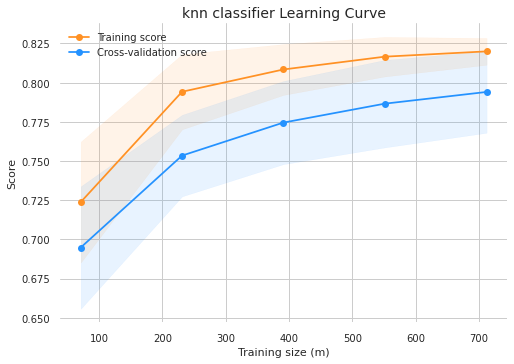

In [102]:

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold, StratifiedShuffleSplit,learning_curve
def plot_learning_curve(estimator1, X, y, ylim=None, cv=None,n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    f, ax1 = plt.subplots()
    # First Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator1, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax1.set_title("knn classifier Learning Curve", fontsize=14)
    ax1.set_xlabel('Training size (m)')
    ax1.set_ylabel('Score')
    ax1.grid(True)
    ax1.legend(loc="best")
    return plt
cv = StratifiedShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plot_learning_curve(knn_restimator, X, y, cv=cv, n_jobs=4)

In [103]:
test_prediction = sv_estimator.predict(test)

In [104]:
test_data=pd.read_csv("../input/titanic/test.csv")

In [105]:
submission = pd.DataFrame({
        "PassengerId":test_data.PassengerId,
        "Survived": test_prediction
    })

In [106]:
submission.PassengerId = submission.PassengerId.astype(int)
submission.Survived = submission.Survived.astype(int)

In [107]:
submission.to_csv("titanic_1st_submission.csv", index=False)